# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
btc_response_data = requests.get(btc_url).json()
btc_price = btc_response_data['data']['1']['quotes']['USD']['price']
btc_price

# Fetch current ETH price
eth_response_data = requests.get(eth_url).json()
eth_price = eth_response_data['data']['1027']['quotes']['USD']['price']
eth_price
# # Compute current value of my crpto

my_btc_value = my_btc*btc_price
my_eth_value = my_eth*eth_price
# # Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $34117.20
The current value of your 5.3 ETH is $8430.34


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
alpaca_api_key
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [8]:
alpaca_api_key

'PKYKC9AD5CG4N1XKC8TS'

In [9]:
# Format current date as ISO format
today = pd.Timestamp("2023-07-28", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today
).df
df_portfolio

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2023-07-28 04:00:00+00:00,97.56,97.59,97.3102,27240,97.39,9233678,97.517341,AGG
2023-07-28 04:00:00+00:00,456.92,457.78,452.4918,528395,455.88,80011791,456.263985,SPY


In [10]:
# Reorganize the DataFrame
# Separate ticker data
AGG = df_portfolio[df_portfolio['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis=1)



# Concatenate the ticker DataFrames
df_portfolio = pd.concat([AGG, SPY],axis=1, keys=['AGG','SPY'])

# Preview DataFrame
df_portfolio

AGG                                              \
                           close   high      low trade_count   open   volume   
timestamp                                                                      
2023-07-28 04:00:00+00:00  97.56  97.59  97.3102       27240  97.39  9233678   

                                         SPY                                \
                                vwap   close    high       low trade_count   
timestamp                                                                    
2023-07-28 04:00:00+00:00  97.517341  456.92  457.78  452.4918      528395   

                                                         
                             open    volume        vwap  
timestamp                                                
2023-07-28 04:00:00+00:00  455.88  80011791  456.263985

In [11]:
df_portfolio["AGG"]["close"].values[0]

97.56

In [12]:
# Pick AGG and SPY close prices
agg_close_price = df_portfolio["AGG"]["close"].values[0]
spy_close_price = df_portfolio["SPY"]["close"].values[0]
# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $97.56
Current SPY closing price: $456.92


In [13]:
# Compute the current value of shares
agg_value = agg_close_price * my_agg
spy_value = spy_close_price *my_spy


# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${agg_value:0.2f}")

The current value of your 50 SPY shares is $22846.00
The current value of your 200 AGG shares is $19512.00


### Savings Health Analysis

In [14]:
# Set monthly household income
monthly_household_income = 12000

# Consolidate financial assets data
investments = {"crypto" : my_btc_value+my_eth_value, 
              "shares" : agg_value+spy_value}

# Create savings DataFrame
df_savings = pd.DataFrame(investments.items()).set_index(0)

# Display savings DataFrame
display(df_savings)

,1
0,
crypto,42547.539
shares,42358.000


<AxesSubplot:xlabel='0'>

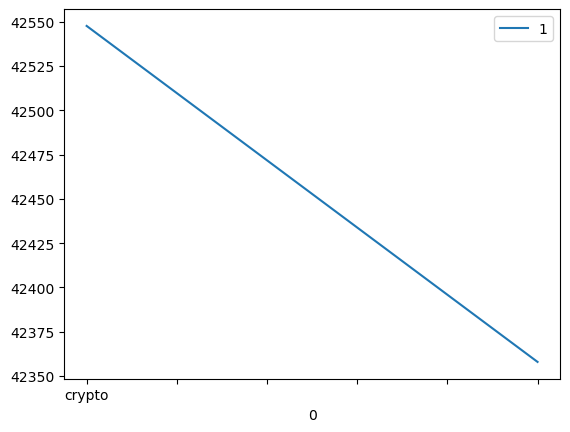

In [15]:
# Plot savings pie chart
df_savings.plot()

In [16]:
# Set ideal emergency fund
emergency_fund = monthly_household_income * 3

# Calculate total amount of savings
crypto = df_savings.iloc[0, 0]
shares = df_savings.iloc[1, 0]
total_savings =crypto+shares
total_savings-emergency_fund

# Validate saving health
if total_savings > emergency_fund:
     print("congratulation on your savings")
elif total_savings == emergency_fund:
     print("congratulations")
elif total_savings < emergency_fund:
     print(emergency_fund-total_savings)
    

congratulation on your savings


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [17]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [18]:
# Get 5 years' worth of historical data for SPY and AGG
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = df_portfolio[df_portfolio['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis=1)


# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG, SPY],axis=1, keys=['AGG','SPY'])

# Display sample data
df_stock_data.head()

AGG                                          \
                             close      high       low trade_count    open   
timestamp                                                                    
2016-05-02 04:00:00+00:00  110.605  110.7400  110.5200       15122  110.74   
2016-05-03 04:00:00+00:00  110.810  110.9450  110.7500       15663  110.89   
2016-05-04 04:00:00+00:00  110.860  110.9315  110.7595       13984  110.91   
2016-05-05 04:00:00+00:00  111.140  111.1600  110.8010       15708  110.92   
2016-05-06 04:00:00+00:00  110.970  111.1200  110.9700       12697  111.12   

                                                     SPY                  \
                            volume        vwap     close    high     low   
timestamp                                                                  
2016-05-02 04:00:00+00:00  3608552  110.626939  207.9700  208.18  206.41   
2016-05-03 04:00:00+00:00  3128774  110.864495  206.1592  206.80  205.28   
2016-05-04 04:00:00+00:00  3096337  110.877983  205.0100  205.85  204.42   
2016-05-05 04:00:00+00:00  3052967  111.030002  204.9700  205.98  204.47   
2016-05-06 04:00:00+00:00  2922700  111.027631  205.7200  205.77  203.88   

                                                                      
                          trade_count    open     volume        vwap  
timestamp                                                             
2016-05-02 04:00:00+00:00      263586  206.92   64747229  207.305695  
2016-05-03 04:00:00+00:00      377523  206.52  108050343  206.309997  
2016-05-04 04:00:00+00:00      345266  204.99   94995641  205.086315  
2016-05-05 04:00:00+00:00      280626  205.56   68425268  205.140615  
2016-05-06 04:00:00+00:00      340162  204.06   90999800  204.943796

In [19]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyear = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.60,.40],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [20]:
# Printing the simulation input data
MC_thirtyyear.portfolio_data.head()

AGG                                          \
                             close      high       low trade_count    open   
timestamp                                                                    
2016-05-02 04:00:00+00:00  110.605  110.7400  110.5200       15122  110.74   
2016-05-03 04:00:00+00:00  110.810  110.9450  110.7500       15663  110.89   
2016-05-04 04:00:00+00:00  110.860  110.9315  110.7595       13984  110.91   
2016-05-05 04:00:00+00:00  111.140  111.1600  110.8010       15708  110.92   
2016-05-06 04:00:00+00:00  110.970  111.1200  110.9700       12697  111.12   

                                                                  SPY          \
                            volume        vwap daily_return     close    high   
timestamp                                                                       
2016-05-02 04:00:00+00:00  3608552  110.626939          NaN  207.9700  208.18   
2016-05-03 04:00:00+00:00  3128774  110.864495     0.001853  206.1592  206.80   
2016-05-04 04:00:00+00:00  3096337  110.877983     0.000451  205.0100  205.85   
2016-05-05 04:00:00+00:00  3052967  111.030002     0.002526  204.9700  205.98   
2016-05-06 04:00:00+00:00  2922700  111.027631    -0.001530  205.7200  205.77   

                                                                              \
                              low trade_count    open     volume        vwap   
timestamp                                                                      
2016-05-02 04:00:00+00:00  206.41      263586  206.92   64747229  207.305695   
2016-05-03 04:00:00+00:00  205.28      377523  206.52  108050343  206.309997   
2016-05-04 04:00:00+00:00  204.42      345266  204.99   94995641  205.086315   
2016-05-05 04:00:00+00:00  204.47      280626  205.56   68425268  205.140615   
2016-05-06 04:00:00+00:00  203.88      340162  204.06   90999800  204.943796   

                                        
                          daily_return  
timestamp                               
2016-05-02 04:00:00+00:00          NaN  
2016-05-03 04:00:00+00:00    -0.008707  
2016-05-04 04:00:00+00:00    -0.005574  
2016-05-05 04:00:00+00:00    -0.000195  
2016-05-06 04:00:00+00:00     0.003659

In [21]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\16477\Downloads\Starter_Code (5)\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003172,1.000182,0.999492,1.000746,1.002823,1.000402,1.000287,0.994575,1.008913,0.993624,...,1.002468,0.999509,1.005507,1.000343,1.006478,0.996648,0.996494,1.002716,1.000991,1.008925
2,1.006587,0.990479,0.999159,0.997424,1.004540,0.994405,0.994401,0.993468,1.005809,0.993184,...,1.000676,1.006870,0.999442,0.996587,1.000691,0.991853,0.994975,1.006110,0.999765,1.009815
3,1.002536,0.992127,1.004639,1.002579,1.010355,0.996906,0.988816,0.995370,1.009216,0.991170,...,1.006821,1.004087,0.995110,0.996818,0.994715,0.994809,0.993943,0.996637,0.996518,1.008727
4,1.006580,0.982208,1.006115,1.004918,1.016154,0.993646,0.991807,0.999866,1.009821,0.994350,...,1.013174,1.007018,0.995970,0.985316,1.004368,0.991905,0.993185,0.995343,0.998550,1.005710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,4.318352,6.898220,6.489603,6.980244,6.027796,5.430417,4.147039,9.538611,7.895630,3.245622,...,12.114964,3.722337,4.701002,7.147258,5.581375,4.853676,10.093069,8.105335,6.942978,7.708222
7557,4.300094,6.862056,6.450414,6.972039,5.982187,5.393940,4.160505,9.472846,7.882087,3.249155,...,12.184439,3.690458,4.726031,7.125360,5.586859,4.839414,10.136271,8.140891,6.970067,7.733864
7558,4.280443,6.862712,6.445572,7.014477,5.957221,5.405505,4.164557,9.422512,7.847942,3.234245,...,12.174532,3.689115,4.752363,7.128404,5.631547,4.842296,10.116538,8.128679,7.028183,7.733699
7559,4.271459,6.922380,6.426846,6.953671,5.998381,5.421083,4.167232,9.446388,7.841062,3.222401,...,12.192163,3.700168,4.743197,7.178318,5.675920,4.816862,10.099820,8.074814,7.024751,7.737833


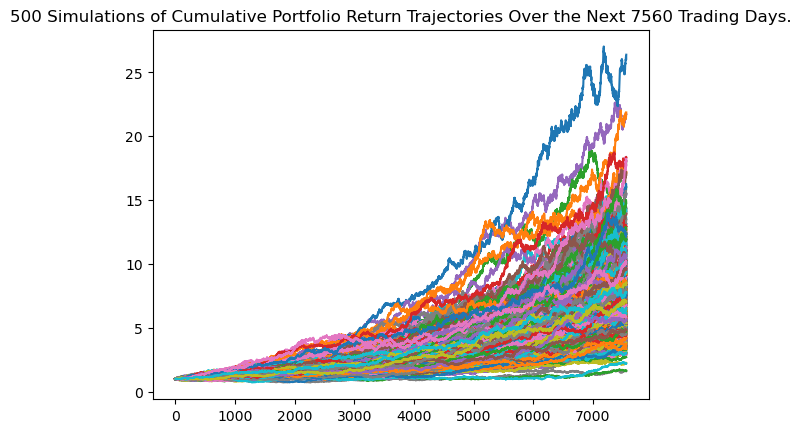

In [22]:
# Plot simulation outcomes
line_plot = MC_thirtyyear.plot_simulation()


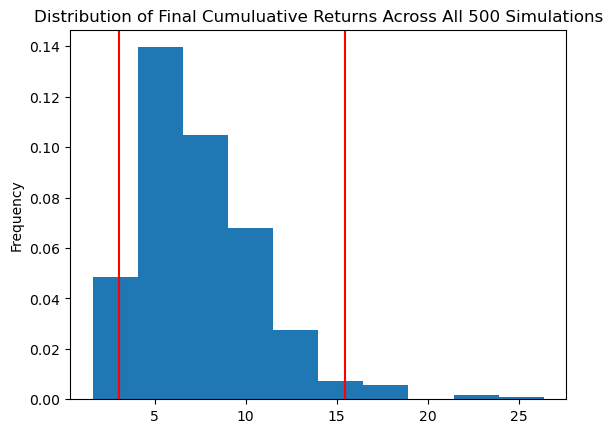

In [23]:
# Plot probability distribution and confidence intervals
dist_plot = MC_thirtyyear.plot_distribution()

### Retirement Analysis

In [24]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_thirtyyear.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              7.460820
std               3.283911
min               1.594110
25%               5.035761
50%               6.857922
75%               9.278114
max              26.384763
95% CI Lower      3.024674
95% CI Upper     15.485984
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [25]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*20000,2)
ci_upper = round(tbl[9]*20000,2)


# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $60493.47 and $309719.68


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [26]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ici_lower = round(tbl[8]*30000,2)
ici_upper = round(tbl[9]*30000,2)


# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $60493.47 and $309719.68


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [27]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns



In [28]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [29]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [30]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [31]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [32]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

NameError: name 'ci_lower_five' is not defined

### Ten Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")